#### Counting People with transfer learning

**Date:** 29/01/2023

**Author:** Christian Shackleton

**Project:** Count the number of people present in an image, using transfer learning from a pretrained model.

**Dataset:** 2000 security camera video stills. Images are from same camera, and show between 0 and 55 people. Images are (640, 480, 3).jpgs (rgb).

**Model type:** Regression.

**Pretrained model:** Inception_ResNet_v2 

**Accuracy metrics:**
For Regression task, Mean Absolute Error (MAE) is commonly used as a metric for regression tasks, as it measures the average absolute difference between the predicted and actual values, whereas in classification tasks accuracy is commonly used. In Accuracy, an answer of 23 when there are 24 people would be considered just as incorrect as 0 people.

**Optimizers:**
The Adam optimizer is an extension to gradient descent techniques such as AdaGrad & RMSProp, and allows for automatic adaption of the learning rate for each input variable for the objective function. By smoothing the search process using a exppdentially decreasing moving average, it enables effective use of of learning rates.

**Activation Function:**
The activation function is responsible for transforming the summed weighted input from the node into the activation of the node or output for that input. A common choice, ReLu, is a piecewise linear function that outputs the input directly if it is positive, otherwise, it will output zero. It is easier to train and often achieves good performance, along with being able to handle the vanishing gradient problem unlike sigmoid, which is why it has become the default activation function for many types of neural networks, and for this project. For final Layer output, either None or a linear activation will be used, as the return is a count.

**Intended Steps:**
1. Source Data & Labels, Set up Folder Structure.
2. Import required libraries, including Tensorflow.Keras
3. Import data and perform manipulation to ensure required type and format.
4. Splitting the data into three sets: training (70%), validation (15%), and test (15%) using the take() and skip() functions of the tf.data.Dataset class. Also perform Batch, Repeat, and Prefetch for performance optimisation.
5. Build transfer learned Model incorporating weights with the InceptionResNetV2 model from the tensorflow.keras.applications library.
6. Compile and fit the model, using adaptive learning rate and early stop callbacks.
7. Train and validate the model, then evaluate using test data.
8. Inspect Loss, MAE, Predicted vs. True, and Residual graphs.
9. Save model and update parameters as required to improve performance.

### Libraries

In [1]:
import os  # Allows for interaction with the operating system, such as file and directory manipulation.

import numpy as np  # Numerical python library for handling arrays and matrices
import pandas as pd  # Data manipulation and analysis library
import matplotlib.pyplot as plt  # Plotting library
from sklearn.metrics import mean_squared_error

import tensorflow as tf  # Machine Learning library
from tensorflow.keras import Model  # Model is a fundamental building block for creating a neural network
from tensorflow.keras import layers  # Layers module of keras library, covers all the ones below.

from tensorflow.keras.optimizers import Adam # Adam optimizer for gradient descent
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2 # InceptionResNetV2 model of keras application library
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input # preprocessing function for input images.

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
# Check TF version and if GPU is available
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.5.0
Keras Version: 2.5.0

GPU is available


In [3]:
# File Paths
img_dir = '../data/frames/'
labels_path = '../data/labels.csv'
save_path = '../models/'

### Data Handling

In [4]:
# Load Labels
label_df = pd.read_csv(labels_path)  # Load the labels.csv file

label_df.columns = ['Image_Name', 'Class']  # Set label column alias
label_df['Image_Name'] = label_df['Image_Name'].map('seq_{:06d}.jpg'.format) # Map each id to its appropriate file name
label_df['Image_Name_Path'] = img_dir + label_df['Image_Name'] # Create image file paths

# Check number of images in directory
print(f'Number of Images in directory: {len(os.listdir(img_dir))}')

# Create lists of image names and class labels
file_paths_list = label_df['Image_Name_Path'].to_list()
labels_list = label_df['Class'].to_list()

Number of Images in directory: 2000


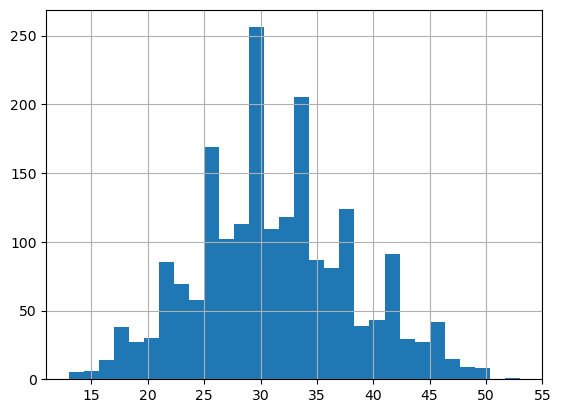

In [5]:
# Generate histogram of number of images vs number of people present.
label_df['Class'].hist(bins=30);

In [6]:
# Create a tensor dataset from the image file names and labels
train_ds = tf.data.Dataset.from_tensor_slices((file_paths_list, labels_list))

# Set image size
image_size = 299

# Function to load and preprocess the images
def load_match_preprocess_images(file_paths_list, label):
    image = tf.io.read_file(file_paths_list)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, (image_size, image_size))
    image = tf.keras.applications.inception_resnet_v2.preprocess_input(image)
#     image = tf.image.convert_image_dtype(image, tf.float32)
#     image = image / 255

    return image, label


# Apply function to map image files with dataset
train_ds = train_ds.map(load_match_preprocess_images)

Metal device set to: Apple M1 Pro


2023-01-30 14:21:32.210486: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-30 14:21:32.210615: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2023-01-30 14:21:32.293219: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-30 14:21:32.293374: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data

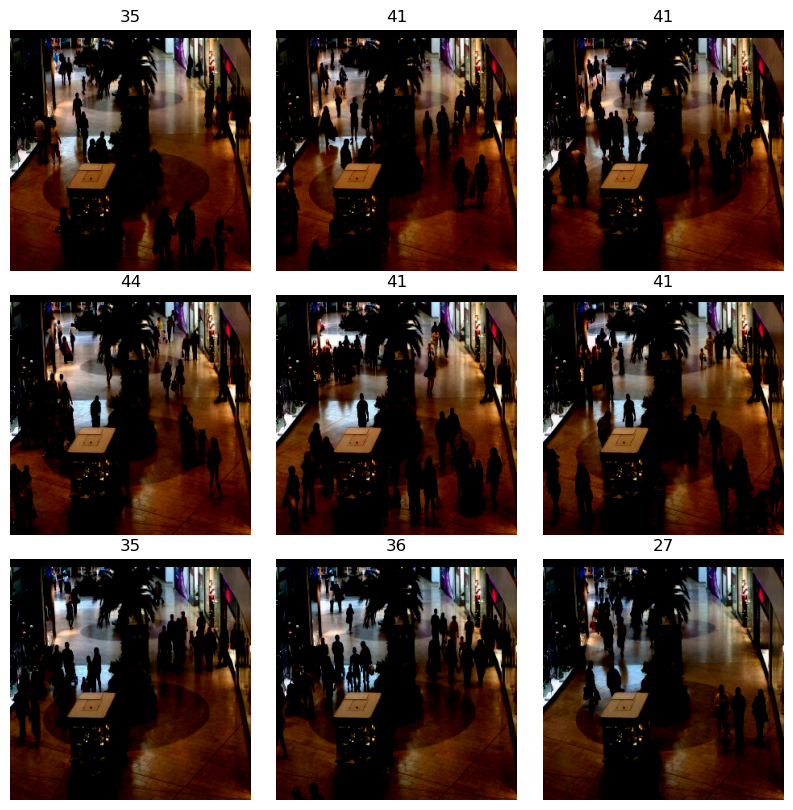

In [7]:
# Visualise data set Images
fig, axs = plt.subplots(3,3, figsize=(10,10))
plt.subplots_adjust(hspace=0.1,wspace=0.1)
plt.title('Visualisaton of Data')
axs = axs.ravel()

for i, (image, label) in enumerate(train_ds.take(9)):
    axs[i].imshow(image.numpy())
    axs[i].set_title(label.numpy())
    axs[i].axis('off')
plt.show()

In [8]:
samples = int(len(file_paths_list))
batch_size = 32
test_batch_size = 30  # Due to length

# Shuffle the data before batching
full_ds = train_ds.shuffle(buffer_size=samples)

# Split the data into a training set (70%) and a validation set (15%), and test set(15%)
train_count = int(0.7 * samples)
val_count = int(0.15 * samples)
test_count = int(0.15 * samples)

train_ds = full_ds.take(train_count)
val_ds = full_ds.skip(train_count).take(val_count)
test_ds = full_ds.skip(train_count + val_count).take(test_count)

print(f'Number of items in full dataset: {samples}')
print(f'Number of items in train dataset: {len(train_ds)}')
print(f'Number of items in validation dataset: {len(val_ds)}')
print(f'Number of items in test dataset: {len(test_ds)}')

# Batch the data
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)
test_ds = test_ds.batch(30)

# Repeat the dataset for multiple epochs
train_ds = train_ds.repeat()
val_ds = val_ds.repeat()
test_ds = test_ds.repeat()

# Prefetch the next batch while training
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Number of items in full dataset: 2000
Number of items in train dataset: 1400
Number of items in validation dataset: 300
Number of items in test dataset: 300


### Model Setup

In [9]:
# Create the base pre-trained model
def build_model_pretrained():
    inputs = layers.Input(shape=(299, 299, 3))

    model = InceptionResNetV2(
        include_top = False,  # We don't include the fully-connected layer at the top of the network - we need to modify the top.
        weights = 'imagenet',  # Load the pretrained weights, trained on the ImageNet dataset.
        )

    # Freeze the pretrained weights
    model.trainable = False
    
    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(inputs)
    x = layers.Dense(1024, activation = "relu")(x)
    x = layers.Dense(1024, activation = "relu")(x) 
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation = 'relu')(x)

    # Compile
    model = Model(inputs, outputs)

    loss = "mean_squared_error"  # This is a classic regression score - the lower the better
    optimizer = Adam(learning_rate=0.0001)  # Adam is an extension to stochastic gradient descent. Usually more effective and fast. # LR controls how much weights are updated each round of training.
    metrics = ['mean_absolute_error']
    model.compile(optimizer=optimizer, loss=loss, metrics= metrics)

    return model

# model.summary()

# Build the model
model = build_model_pretrained()

In [10]:
# Fitting the model weights
"""
Callbacks:
ReduceLROnPlateau callback monitors the validation loss and reduce the learning rate by a factor of 0.1 when the 
validation loss stops improving after 2 epochs. It will also set a minimum learning rate of 1e-6.

EarlyStopping callback monitors the validation loss and stop the training after 5 epochs without any improvement. 
It will also restore the best weights found during training.
"""
# Define the callback for learning rate annealing.
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, verbose = 1, min_lr = 1e-6)

# Define the callback for early stopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)


# Fitting the model
history = model.fit(
    train_ds,
    validation_data = val_ds,
    batch_size = batch_size,
    epochs = 50,
    verbose=1,
#     verbose=0,
    steps_per_epoch = train_count//batch_size,
    validation_steps = val_count//batch_size,
    callbacks = [reduce_lr, early_stop], 
)

Epoch 1/50


2023-01-30 14:21:34.949074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


42/43 [============================>.] - ETA: 0s - loss: 1012.5916 - mean_absolute_error: 31.0475

2023-01-30 14:21:36.139654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 3s 45ms/step - loss: 1013.0494 - mean_absolute_error: 31.0552 - val_loss: 948.2147 - val_mean_absolute_error: 30.0845
Epoch 2/50
43/43 [==============================] - 1s 30ms/step - loss: 929.9610 - mean_absolute_error: 29.6780 - val_loss: 823.7714 - val_mean_absolute_error: 27.8757
Epoch 3/50
43/43 [==============================] - 3s 63ms/step - loss: 754.8915 - mean_absolute_error: 26.5664 - val_loss: 610.2980 - val_mean_absolute_error: 23.7715
Epoch 4/50
43/43 [==============================] - 1s 31ms/step - loss: 460.3891 - mean_absolute_error: 20.2365 - val_loss: 297.0884 - val_mean_absolute_error: 15.7506
Epoch 5/50
43/43 [==============================] - 3s 60ms/step - loss: 181.2806 - mean_absolute_error: 11.5927 - val_loss: 97.4880 - val_mean_absolute_error: 8.0467
Epoch 6/50
43/43 [==============================] - 2s 41ms/step - loss: 66.7185 - mean_absolute_error: 6.5391 - val_loss: 47.0391 - val_mean_absolute_error: 5.2661
Ep

### Results

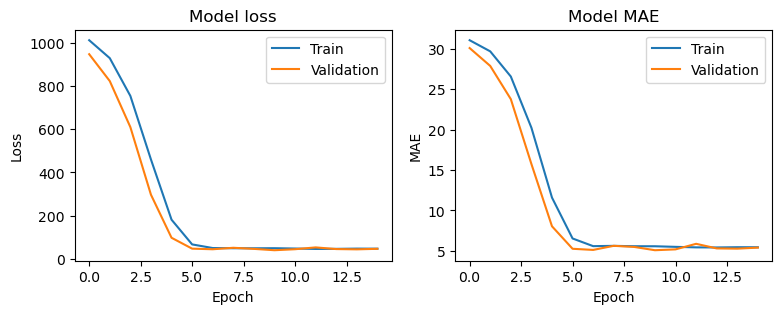

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))

# Plot the training and validation loss
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')

# Plot the training and validation MAE
ax[1].plot(history.history['mean_absolute_error'])
ax[1].plot(history.history['val_mean_absolute_error'])
ax[1].set_title('Model MAE')
ax[1].set_ylabel('MAE')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper right')

plt.show()

### Evaluate Model

In [12]:
results = model.evaluate(test_ds, batch_size = test_batch_size, steps = test_count//test_batch_size)

print("Training & Validation Results")
print(f'Number of training epochs run: {history.epoch[-1]}')

print(f'\nTraining Loss: {history.history["loss"][-1]:.2f}. Training MAE: {history.history["mean_absolute_error"][-1]:.2f}')
print(f'Validation Loss: {history.history["val_loss"][-1]:.2f}. Validation MAE: {history.history["val_mean_absolute_error"][-1]:.2f}')

print("\nTesting & Evaluation")
print(f'Test Loss: {results[0]:.2f}. Test MAE: {results[1]:.2f}')

10/10 [==============================] - 1s 17ms/step - loss: 41.8142 - mean_absolute_error: 5.0847
Training & Validation Results
Number of training epochs run: 14

Training Loss: 46.90. Training MAE: 5.46
Validation Loss: 46.33. Validation MAE: 5.41

Testing & Evaluation
Test Loss: 41.81. Test MAE: 5.08


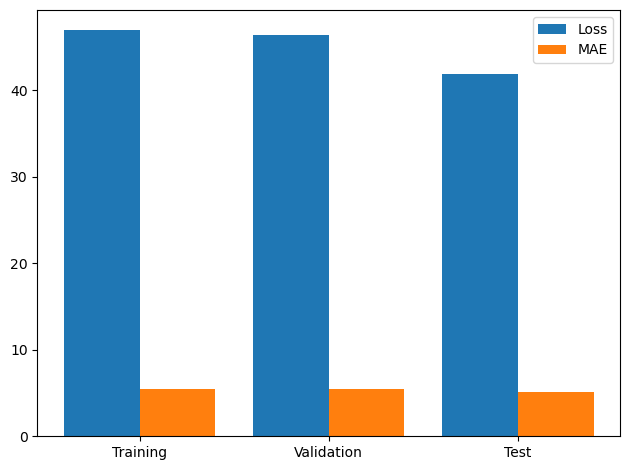

In [13]:
loss = [history.history["loss"][-1], history.history["val_loss"][-1], results[0]]
mae = [history.history["mean_absolute_error"][-1], history.history["val_mean_absolute_error"][-1], results[1]]

fig, ax = plt.subplots()
index = np.arange(3)
bar_width = 0.4

bar1 = ax.bar(index, loss, bar_width, label='Loss')
bar2 = ax.bar(index + bar_width, mae, bar_width, label='MAE')

ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['Training', 'Validation', 'Test'])
ax.legend()

fig.tight_layout()

plt.show()

In [14]:
# Use the model to make predictions on the test set
predictions = model.predict(test_ds, steps = test_count//test_batch_size)

# Generate test_labels for use in prediction.
test_labels = labels_list[train_count + val_count:]

# Plotting Setup
predictions_array = np.squeeze(predictions)
test_labels_array = np.array(test_labels)

2023-01-30 14:22:05.167710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [15]:
# Generate test_labels for use in prediction.
test_labels = labels_list[train_count + val_count:]

# Plotting Setup
predictions_array = np.squeeze(predictions)
test_labels_array = np.array(test_labels)

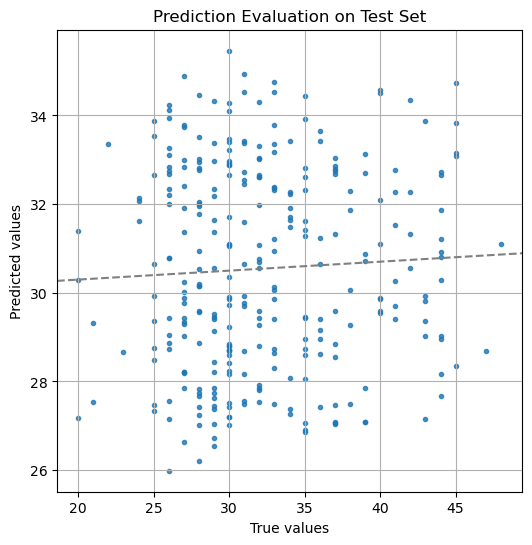

In [16]:
# Plot the Predicted vs Actual counts.
df_predictions = pd.DataFrame({'True values': test_labels_array, 'Predicted values': predictions_array})
ax = df_predictions.plot.scatter('True values', 'Predicted values', alpha=0.8, s=9, figsize=(6,6))

coefficients = np.polyfit(df_predictions['True values'], df_predictions['Predicted values'], 1)
x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
y = coefficients[0] * x + coefficients[1]
ax.plot(x, y, '--', color='gray')

ax.set_title('Prediction Evaluation on Test Set')
ax.grid(axis='both')
ax.autoscale(enable=False, axis='both')
plt.show()

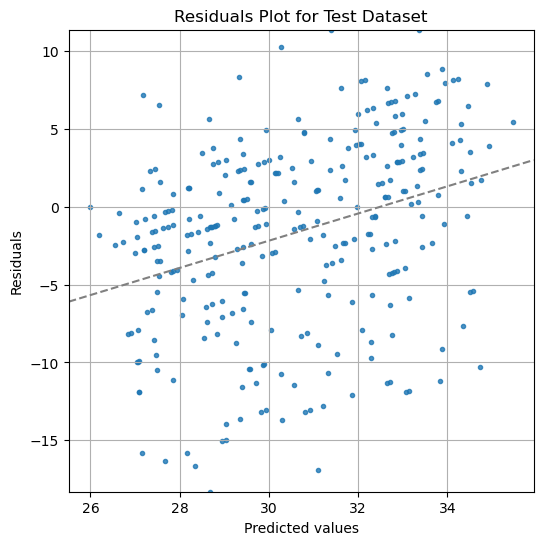

In [17]:
# Plot the residuals 
"""
A residuals plot is a scatter plot of the predicted values versus the residuals (the difference between the 
predicted values and the actual values). This plot can help you understand the model's performance and identify 
any patterns in the errors such as heteroscedasticity, non-linearity, or outliers.
residuals = predictions_array - test_labels_array
"""
residuals = predictions_array - test_labels_array

df_residuals = pd.DataFrame({'Predicted values': predictions_array, 'Residuals': residuals})
ax = df_residuals.plot.scatter('Predicted values', 'Residuals', alpha=0.8, s=9, figsize=(6,6))

coefficients = np.polyfit(df_residuals['Predicted values'], df_residuals['Residuals'], 1)
x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
y = coefficients[0] * x + coefficients[1]
ax.plot(x, y, '--', color='gray')

ax.set_title('Residuals Plot for Test Dataset')
ax.grid(axis='both')
ax.autoscale(enable=True, axis='both', tight=True)
plt.show()

In [18]:
# # Save the model for future use
# save_path = save_path
# model_name = 'InceptionResNetv2_TransferModel'
# version = f'_MAE_{results[1]:.2f}'

# model.save(
#     (save_path + model_name + version + '.h5'),
#     include_optimizer=True
#     )